# Profiling the reader with a realistic example

In [1]:
import ctypes
import time
import glob

import numba
import ROOT
c = ROOT.TCanvas()

Welcome to JupyROOT 6.11/01


The function we'll use as a test is going to make a histogram of Z mass for a large dataset. To keep the histogramming part from slowing down the I/O part, we need direct access to histogram filling.

In [2]:
h = ROOT.TH1I("h", "", 1000, 0, 500)

# make a function (to get a function pointer) that fills h
ROOT.gInterpreter.Declare("void h_Fill(double x) { h->Fill(x); }")

# turn it into an integer and pass it from C++ to Python
ROOT.gInterpreter.Declare("size_t ptr_h_Fill = reinterpret_cast<size_t>(h_Fill);")

# use Python's ctypes to interpret that integer as a callable function
h_Fill = ctypes.CFUNCTYPE(None, ctypes.c_double)(ROOT.ptr_h_Fill)

`fillmany_pyroot` is a Python function that calls a PyROOT proxy.

`fillmany_direct` is a LLVM-compiled function that directly calls `h_Fill`.

In [3]:
def fillmany_pyroot(howmany):
    for i in range(howmany):
        h.Fill(200)   # note the dot!

@numba.njit
def fillmany_direct(howmany):
    for i in range(howmany):
        h_Fill(300)   # note the underscore!

# call it once to compile it (instead of explicitly spelling out the signature)
fillmany_direct(0)

Compiled code is faster.

In [4]:
%time fillmany_pyroot(10000000)

CPU times: user 11.9 s, sys: 3 s, total: 14.9 s
Wall time: 10.2 s


In [5]:
%time fillmany_direct(10000000)

CPU times: user 148 ms, sys: 0 ns, total: 148 ms
Wall time: 150 ms


In [6]:
6.46 / 0.150              # 6.46 s / 150 ms

43.06666666666667

In [7]:
10000000 / 0.150 * 1e-6   # MHz

66.66666666666667

It also has the desired effect of filling the histogram.

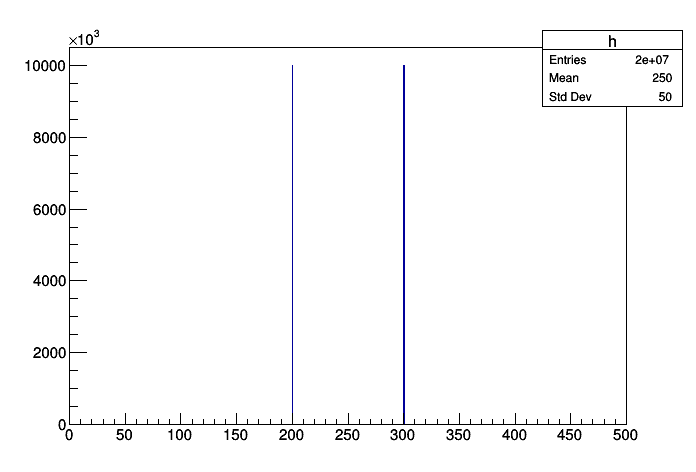

In [8]:
h.Draw(); c.Draw()

Okay! We're ready to run a sample analysis!

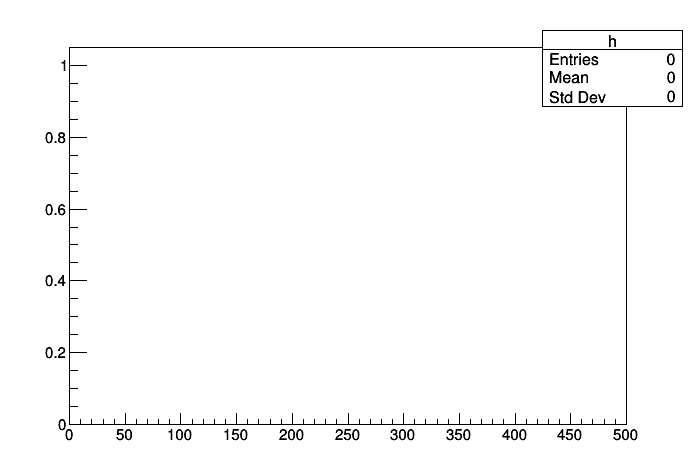

In [9]:
# first clear the histogram
h.Reset(); h.Draw(); c.Draw()

We could do the mass calculation in compiled Python.

Then again, we could do it in ROOT and use the same trick to expose ROOT's `TLorentzVector` to Python.

In [10]:
ROOT.TLorentzVector   # cause ROOT to dyload the library
ROOT.gInterpreter.Declare("""
TLorentzVector v1, v2;
double mass(double pt1, double eta1, double phi1, double pt2, double eta2, double phi2) {
    v1.SetPtEtaPhiM(pt1, eta1, phi1, 0);
    v2.SetPtEtaPhiM(pt2, eta2, phi2, 0);
    return (v1 + v2).M();
}
size_t ptr_mass = reinterpret_cast<size_t>(mass);
""")

mass = ctypes.CFUNCTYPE(ctypes.c_double,                                    # return type
                        ctypes.c_double, ctypes.c_double, ctypes.c_double,  # parameter types
                        ctypes.c_double, ctypes.c_double, ctypes.c_double
                       )(ROOT.ptr_mass)

Load the first file for testing.

In [11]:
f = ROOT.TFile("/mnt/data/DYJetsToLL_M_50_HT_100to200_13TeV_2/DYJetsToLL_M_50_HT_100to200_13TeV_2_0.root")
t = f.Get("Events")

Warning in <TClass::Init>: no dictionary for class baconhep::TEventInfo is available
Warning in <TClass::Init>: no dictionary for class baconhep::TGenEventInfo is available
Warning in <TClass::Init>: no dictionary for class baconhep::TGenParticle is available
Warning in <TClass::Init>: no dictionary for class baconhep::TElectron is available
Warning in <TClass::Init>: no dictionary for class baconhep::TMuon is available
Warning in <TClass::Init>: no dictionary for class baconhep::TTau is available
Warning in <TClass::Init>: no dictionary for class baconhep::TPhoton is available
Warning in <TClass::Init>: no dictionary for class baconhep::TVertex is available
Warning in <TClass::Init>: no dictionary for class baconhep::TJet is available
Warning in <TClass::Init>: no dictionary for class baconhep::TAddJet is available


The following was built up by experimentation on the first file, then wrapped up as a function (with Numba signature).

In [12]:
#           return type     (argument types)
@numba.njit(numba.types.none(numba.types.int32[:],
                             numba.types.float32[:],
                             numba.types.float32[:],
                             numba.types.float32[:]))
def fillbatch(counter, pt, eta, phi):
    muindex = 0
    for entry in range(len(counter)):
        numMuons = counter[entry]              # counter tells us how many muons there are

        for i in range(numMuons):              # example of looping too complex for Numpy or SQL
            mu1 = muindex + i
            for j in range(i + 1, numMuons):
                mu2 = muindex + j
                h_Fill(mass(pt[mu1], eta[mu1], phi[mu1], pt[mu2], eta[mu2], phi[mu2]))

        muindex += numMuons                    # muindex steps forward with non-uniform stride

It's pretty fast.

In [13]:
startTime = time.time()
for start, end, counter, pt, eta, phi in t.GetNumpyIterator("Muon_", "Muon.pt", "Muon.eta", "Muon.phi"):
    fillbatch(counter, pt, eta, phi)
print(time.time() - startTime)

0.0394780635834


So we do a scan over all the files (21.4 GB). See next page for results.

In [14]:
h.Reset()

startTime = time.time()
totalEvents = 0
totalBytes = 0
totalTime = 0.0
for fname in sorted(glob.glob("/mnt/data/*/*.root")):
    f = ROOT.TFile(fname)
    t = f.Get("Events")

    for start, end, counter, pt, eta, phi in t.GetNumpyIterator("Muon_", "Muon.pt", "Muon.eta", "Muon.phi"):
        fillbatch(counter, pt, eta, phi)
        totalEvents += end - start
        totalBytes += counter.sum() * 4 * 4  # one int32 and three float32

totalTime = time.time() - startTime
ev_per_s = totalEvents / totalTime
mb_per_s = totalBytes / totalTime / 1024**2


Total events: 5389283, total time: 4.9438419342 s, total size: 102 MB
Single-threaded rate: 1090.1 kHz, 20.8 MB/s


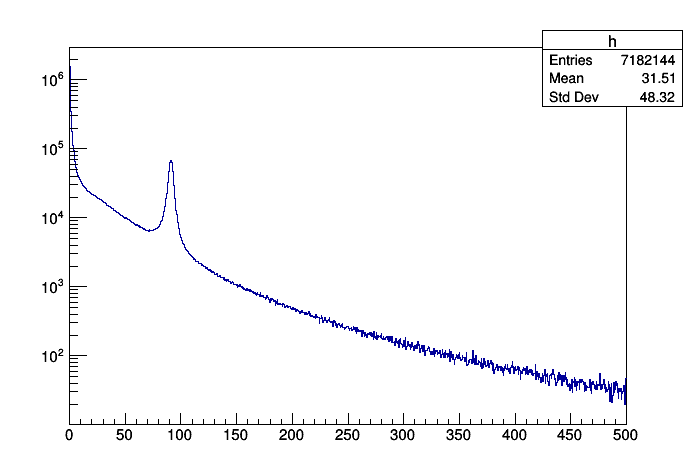

In [15]:
print("""\nTotal events: {}, total time: {} s, total size: {} MB
Single-threaded rate: {:.1f} kHz, {:.1f} MB/s""".format(
    totalEvents, totalTime, totalBytes/1024**2, ev_per_s*1e-3, mb_per_s))
c.SetLogy(); h.Draw(); c.Draw()

On the Python side, I'm developing a library to handle the messy indexing we witnessed in `fillbatch`.

Some of this is independent of ROOT and would be part of that "high level interface" discussed in the first notebook. TBD.

   * [https://github.com/diana-hep/plur](https://github.com/diana-hep/plur)